In [1]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import mat73
    HAVE_MAT73 = True
except Exception:
    HAVE_MAT73 = False

from scipy.io import loadmat

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
def extract_start_res_from_mat(mat_path: str):
    # read mat
    mat = None
    if HAVE_MAT73:
        try:
            mat = mat73.loadmat(mat_path)
        except Exception:
            mat = None
    if mat is None:
        mat = loadmat(mat_path, squeeze_me=True, struct_as_record=False)

    OUT = mat['OUT']

    if isinstance(OUT, dict):
        if 'start_res_ms' in OUT:
            vals = np.array(OUT['start_res_ms']).astype(float).ravel()
            return vals[np.isfinite(vals)]
        else:
            pass

    vals = []
    if isinstance(OUT, (list, tuple, np.ndarray)):
        OUT_flat = OUT.ravel() if isinstance(OUT, np.ndarray) else OUT
        for o in OUT_flat:
            if isinstance(o, dict):
                v = o.get('start_res_ms', np.nan)
            elif hasattr(o, '_fieldnames'):
                try:
                    v = getattr(o, 'start_res_ms')
                except Exception:
                    v = np.nan
            else:
                try:
                    d = dict(o)
                    v = d.get('start_res_ms', np.nan)
                except Exception:
                    v = np.nan
            if np.isscalar(v):
                vals.append(float(v))
            else:
                vv = np.array(v).astype(float).ravel()
                vals.extend(vv.tolist())
        vals = np.array(vals, float)
        return vals[np.isfinite(vals)]

    raise TypeError(f" Unable to parse start_res_ms from {mat_path} ;OUT type:{type(OUT)}")


In [3]:
# Change to your data root directory (which should contain s1, s2, ..., s15)
root_dir = r"D:/Datasets"

# subjects list（s1~s15）
subjects = [f"s{i}" for i in range(1, 16)]

# all eeg_leap_*.mat files in the data directory of each participant
all_vals = []
per_subject_counts = {}

for sid in subjects:
    data_dir = os.path.join(root_dir, sid, "preprocessed data\motion_execution")
    files = sorted(glob.glob(os.path.join(data_dir, "eeg_leap_*.mat")))
    if not files:
        alt_data_dir = os.path.join(root_dir, f"{sid:>s}", "preprocessed data\motion_execution")
        files = sorted(glob.glob(os.path.join(alt_data_dir, "eeg_leap_*.mat")))

    subj_vals = []
    for fp in files:
        try:
            vals = extract_start_res_from_mat(fp)
            if vals.size:
                subj_vals.append(vals)
        except Exception as e:
            print(f"[Skip] {fp} parsing faild: {e}")

    if subj_vals:
        subj_vals = np.concatenate(subj_vals)
        all_vals.append(subj_vals)
        per_subject_counts[sid] = subj_vals.size
    else:
        per_subject_counts[sid] = 0

# summary
if all_vals:
    all_vals = np.concatenate(all_vals).astype(float)
else:
    all_vals = np.array([], float)

print("Summary number of trials:", all_vals.size)
print("Number of trials whth pre subject:", per_subject_counts)

Summary number of trials: 6720
Number of trials whth pre subject: {'s1': 311, 's2': 398, 's3': 479, 's4': 473, 's5': 471, 's6': 475, 's7': 453, 's8': 455, 's9': 454, 's10': 475, 's11': 480, 's12': 385, 's13': 467, 's14': 465, 's15': 479}


Original sample: 6720, filtered (0 ≤ e ≤ 20 ms): 6678


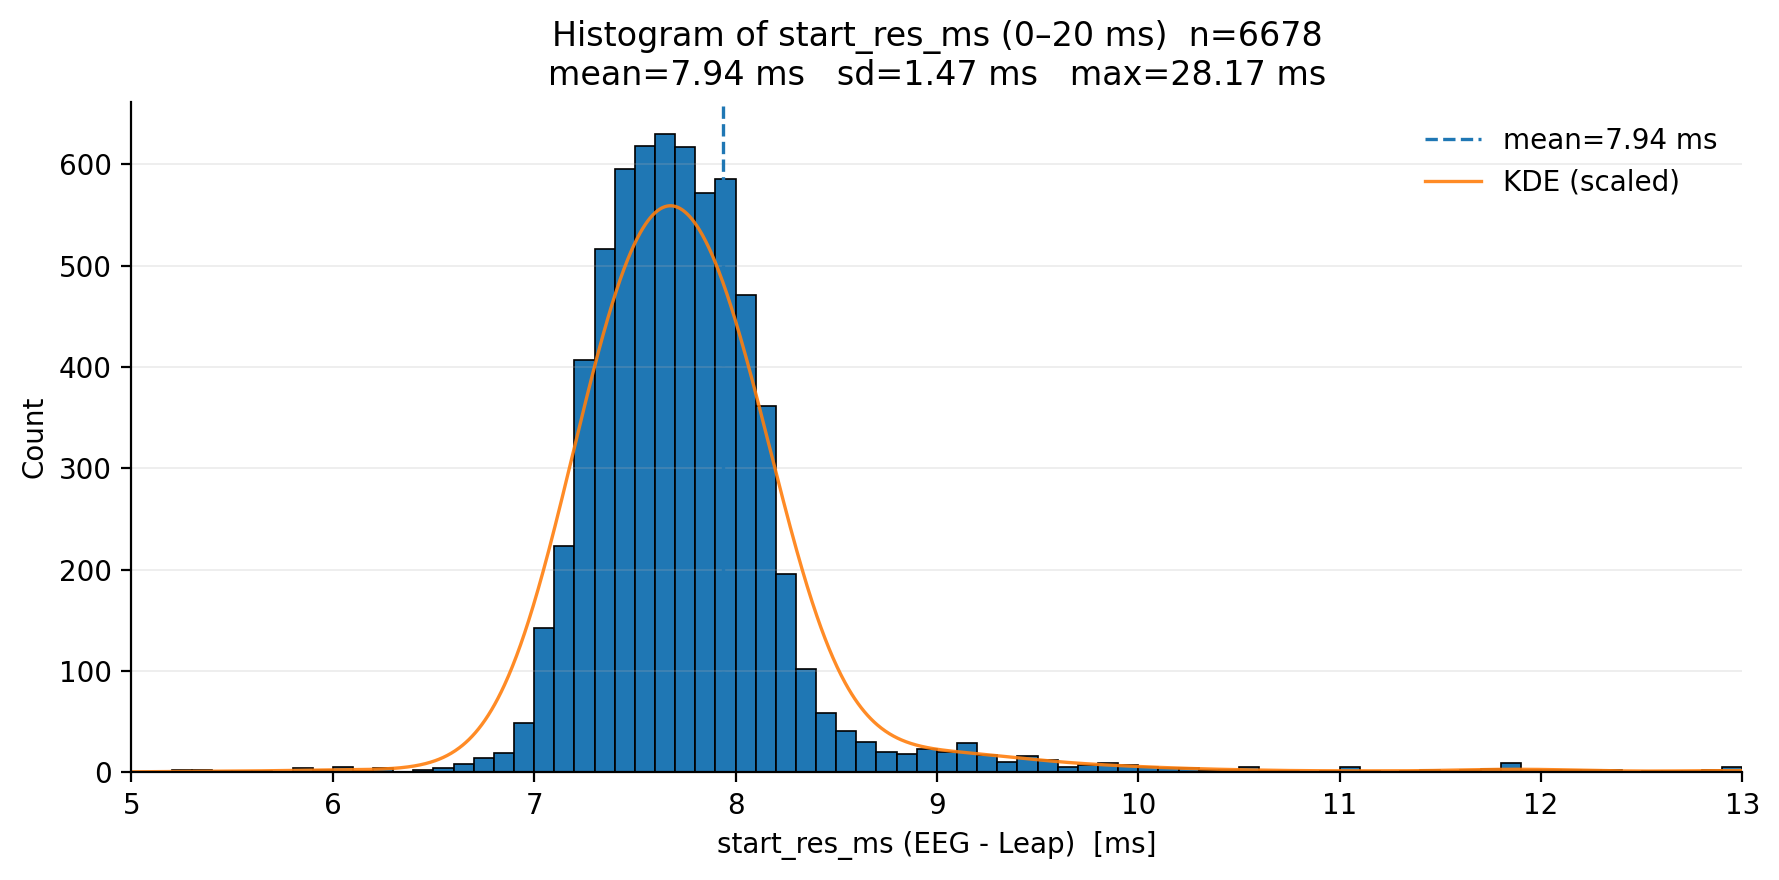

In [4]:
from scipy.stats import gaussian_kde

vals_raw = np.asarray(all_vals, float)

# 1) Filtering: limited, absolute value ≤ 20, and non-negative
mask = np.isfinite(vals_raw) & (np.abs(vals_raw) <= 30.0) & (vals_raw >= 0.0)
vals = vals_raw[mask]
print(f"Original sample: {vals_raw.size}, filtered (0 ≤ e ≤ 20 ms): {vals.size}")

if vals.size == 0:
    print("There is no data to plot after filtering.")
else:
    # 2) Fine histogram: 0.25 ms per bin; range fixed [0, 20]
    bin_width = 0.1
    xmin, xmax = 5.0, 13
    bins = np.arange(xmin, xmax + bin_width, bin_width)

    mean_signed = float(np.mean(vals))
    mean_abs    = float(np.mean(vals))  # mean == mean|e|
    sd_abs      = float(np.std(vals, ddof=1)) if vals.size > 1 else np.nan
    max_abs     = float(np.max(vals))

    fig, ax = plt.subplots(figsize=(9,4.5), dpi=200)

    counts, edges, patches = ax.hist(
        vals, bins=bins, edgecolor='black', linewidth=0.6
    )

    # mean line
    ax.axvline(mean_signed, linestyle='--', linewidth=1.2, label=f"mean={mean_signed:.2f} ms")

    ax.grid(axis='y', alpha=0.25, linewidth=0.6)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('start_res_ms (EEG - Leap)  [ms]')
    ax.set_ylabel('Count')
    ax.set_title(
        f'Histogram of start_res_ms (0–20 ms)  n={vals.size}\n'
        f'mean={mean_signed:.2f} ms   sd={sd_abs:.2f} ms   max={max_abs:.2f} ms'
    )

    # KDE (scaled by "count" metric)
    try:
        kde = gaussian_kde(vals)
        x_plot = np.linspace(xmin, xmax, 2001)
        y_kde = kde(x_plot) * vals.size * bin_width
        ax.plot(x_plot, y_kde, linewidth=1.2, label='KDE (scaled)', alpha=0.9)
    except Exception:
        pass

    ax.legend(frameon=False)
    plt.tight_layout()
    plt.savefig('./start_res_ms.png', dpi=300)
    plt.show()

### Completion time

In [6]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import mat73
    HAVE_MAT73 = True
except Exception:
    HAVE_MAT73 = False

from scipy.io import loadmat

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [7]:
def extract_trials_from_mat(mat_path: str):
    mat = None
    if HAVE_MAT73:
        try:
            mat = mat73.loadmat(mat_path)
        except Exception:
            mat = None
    if mat is None:
        mat = loadmat(mat_path, squeeze_me=True, struct_as_record=False)

    if 'OUT' not in mat:
        raise KeyError(f"No {mat_path} in OUT")

    OUT = mat['OUT']
    records = []

    def _duration_from_tms(tms):
        arr = np.asarray(tms)
        return int(arr.shape[0])

    if isinstance(OUT, dict):
        t_col = OUT.get('t_ms', None)
        c_col = OUT.get('ball_color', None)

        if t_col is None:
            raise KeyError(f"The OUT file of {mat_path} is missing t_ms")

        N = len(t_col)
        for i in range(N):
            t_i = t_col[i]
            dur = _duration_from_tms(t_i)
            color = None
            if c_col is not None:
                try:
                    color = str(c_col[i])
                except Exception:
                    color = None
            records.append({'duration_ms': dur, 'ball_color': color})
        return records

    arr = OUT.ravel() if isinstance(OUT, np.ndarray) else OUT
    for o in arr:
        # 取 t_ms
        if isinstance(o, dict):
            t_i = o.get('t_ms', None)
            color = o.get('ball_color', None)
        elif hasattr(o, '_fieldnames'):  
            try:
                t_i = getattr(o, 't_ms')
            except Exception:
                t_i = None
            try:
                color = getattr(o, 'ball_color')
            except Exception:
                color = None
        else:
            try:
                d = dict(o)
                t_i = d.get('t_ms', None)
                color = d.get('ball_color', None)
            except Exception:
                t_i = None
                color = None

        if t_i is None:
            continue
        dur = _duration_from_tms(t_i)
        color = None if color is None else str(color)
        records.append({'duration_ms': dur, 'ball_color': color})

    return records


In [14]:
# Change to your data root directory
root_dir = r"D:\Datasets"

subjects = [f"s{i}" for i in range(1, 16)]
patterns = ["eeg_leap_L*.mat", "eeg_leap_R*.mat"]  # left/right hand

rows = []
for sid in subjects:
    data_dir = os.path.join(root_dir, sid, "preprocessed data\motion_execution")
    if not os.path.isdir(data_dir):
        print(f"[Skip] {sid},No data catalogue:{data_dir}")
        continue

    for pat in patterns:
        for fp in sorted(glob.glob(os.path.join(data_dir, pat))):
            # Determine left or right hand
            fname = os.path.basename(fp)
            # hand = 'L' if re.search(r'_L', fname, flags=re.IGNORECASE) else ('R' if re.search(r'_R', fname, flags=re.IGNORECASE) else None)
            m = re.search(r'_(L|R)(?=\d|$)', fname, flags=re.IGNORECASE)
            hand = m.group(1).upper() if m else None


            try:
                recs = extract_trials_from_mat(fp)
            except Exception as e:
                print(f"[Skip] parsing failed{fp}: {e}")
                continue

            for r in recs:
                dur = r['duration_ms']
                color = (r['ball_color'] or '').lower()
                # Consistency/Inconsistency: red → Consistency；yellow → Inconsistency
                if color == '"red"':
                    congr = 'congruent'
                elif color == '"yellow"':
                    congr = 'incongruent'
                else:
                    congr = 'unknown'

                rows.append({
                    'subject': sid,
                    'file': fname,
                    'hand': hand,
                    'congruency': congr,
                    'duration_ms': dur
                })

df = pd.DataFrame(rows)
print(df.shape)
df.head()

[Skip] parsing failedD:\Datasets\s12\preprocessed data\motion_execution\eeg_leap_L3.mat: tuple index out of range
(6719, 5)


,subject,file,hand,congruency,duration_ms
0,s1,eeg_leap_L1.mat,L,congruent,282
1,s1,eeg_leap_L1.mat,L,incongruent,470
2,s1,eeg_leap_L1.mat,L,incongruent,336
3,s1,eeg_leap_L1.mat,L,congruent,311
4,s1,eeg_leap_L1.mat,L,congruent,326


In [15]:
df_clean = df.query("hand in ['L','R'] and congruency in ['congruent','incongruent']").copy()
print("number of valid trials:", len(df_clean))

# simple statistics
print(df_clean.groupby(['subject','hand'])['duration_ms'].describe().round(2))

number of valid trials: 6719
              count    mean     std    min     25%    50%     75%    max
subject hand                                                            
s1      L     157.0  398.43   82.34  224.0  336.00  393.0  445.00  606.0
        R     154.0  350.15   70.10  128.0  297.75  350.0  388.75  648.0
s10     L     238.0  208.98   34.44  118.0  185.25  204.5  228.75  372.0
        R     237.0  194.19   31.52  119.0  175.00  194.0  213.00  288.0
s11     L     240.0  225.92   38.86  157.0  201.00  220.0  244.25  488.0
        R     240.0  193.19   30.33  138.0  171.00  191.0  210.00  346.0
s12     L     157.0  273.08   47.78  163.0  244.00  264.0  309.00  411.0
        R     227.0  278.77   45.78  130.0  254.50  279.0  306.50  416.0
s13     L     235.0  209.65   40.45  116.0  180.00  208.0  236.00  325.0
        R     232.0  210.96   42.58   84.0  179.75  209.0  236.00  354.0
s14     L     228.0  235.00   37.16  155.0  209.00  233.0  256.25  376.0
        R     237.0  2

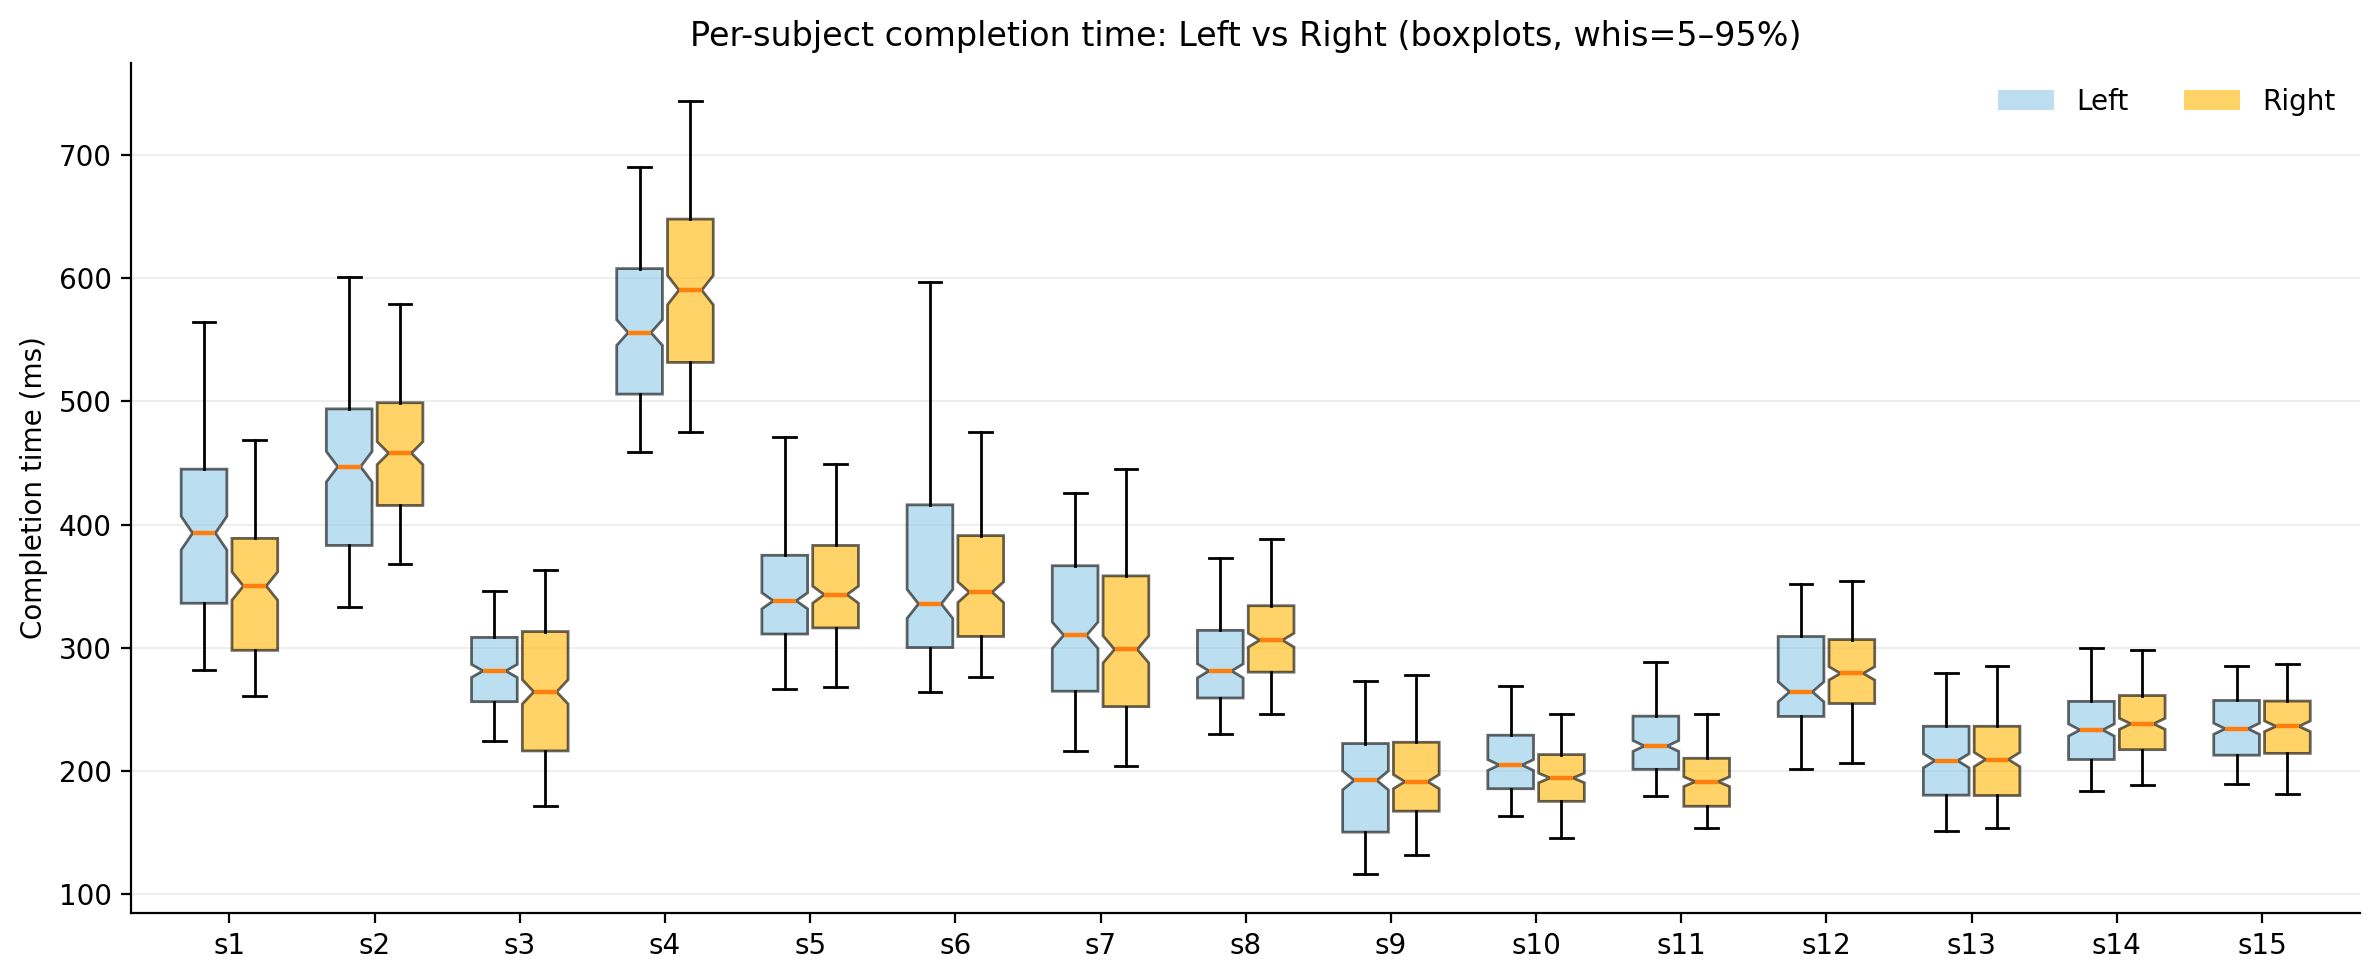

In [16]:
# Construct a list of L/R for each subject from df_clean
subjects_sorted = sorted(df_clean['subject'].unique(), key=lambda s: int(''.join(ch for ch in s if ch.isdigit())))
data_L = []
data_R = []
for sid in subjects_sorted:
    dL = df_clean.query("subject == @sid and hand == 'L'")['duration_ms'].to_numpy()
    dR = df_clean.query("subject == @sid and hand == 'R'")['duration_ms'].to_numpy()
    # If it is empty, an empty array will be used to occupy the position
    data_L.append(dL)
    data_R.append(dR)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

x = np.arange(len(subjects_sorted), dtype=float)
width = 0.35

pos_L = x - width/2
pos_R = x + width/2

fig, ax = plt.subplots(figsize=(12,5), dpi=200)

# Unified box plot style
boxprops   = dict(linewidth=1.0)
medianprops= dict(linewidth=1.6)
whiskerprops=dict(linewidth=1.0)
capprops   = dict(linewidth=1.0)
flierprops = dict(marker='o', markersize=2, alpha=0.25)

# draw the left hand
bpL = ax.boxplot(
    data_L, positions=pos_L, widths=width*0.9, notch=True,
    showfliers=False, whis=(5,95),
    boxprops=boxprops, medianprops=medianprops,
    whiskerprops=whiskerprops, capprops=capprops, patch_artist=True
)
for b in bpL['boxes']:
    b.set_facecolor('#8ecae6')
    b.set_alpha(0.6)

# draw the right hand
bpR = ax.boxplot(
    data_R, positions=pos_R, widths=width*0.9, notch=True,
    showfliers=False, whis=(5,95),
    boxprops=boxprops, medianprops=medianprops,
    whiskerprops=whiskerprops, capprops=capprops, patch_artist=True
)
for b in bpR['boxes']:
    b.set_facecolor('#ffb703')
    b.set_alpha(0.6)

# x-axis and grid
ax.set_xticks(x)
ax.set_xticklabels(subjects_sorted, rotation=0)
ax.set_ylabel('Completion time (ms)')
ax.set_title('Per-subject completion time: Left vs Right (boxplots, whis=5–95%)')
ax.grid(axis='y', alpha=0.25, linewidth=0.6)

# Legend
legend_elems = [Patch(facecolor='#8ecae6', alpha=0.6, label='Left'),
                Patch(facecolor='#ffb703', alpha=0.6, label='Right')]
ax.legend(handles=legend_elems, frameon=False, ncol=2, loc='upper right')

plt.tight_layout()
plt.savefig('./completion time_all_sub.png', dpi=300)
plt.show()


In [21]:
df_left = df_clean.query("hand == 'L'")

groups = [df_left.query("congruency == 'congruent'")['duration_ms'].values,
          df_left.query("congruency == 'incongruent'")['duration_ms'].values]

labels = ['Congruent (red)', 'Incongruent (yellow)']
colors = ['#90be6d', '#f8961e']

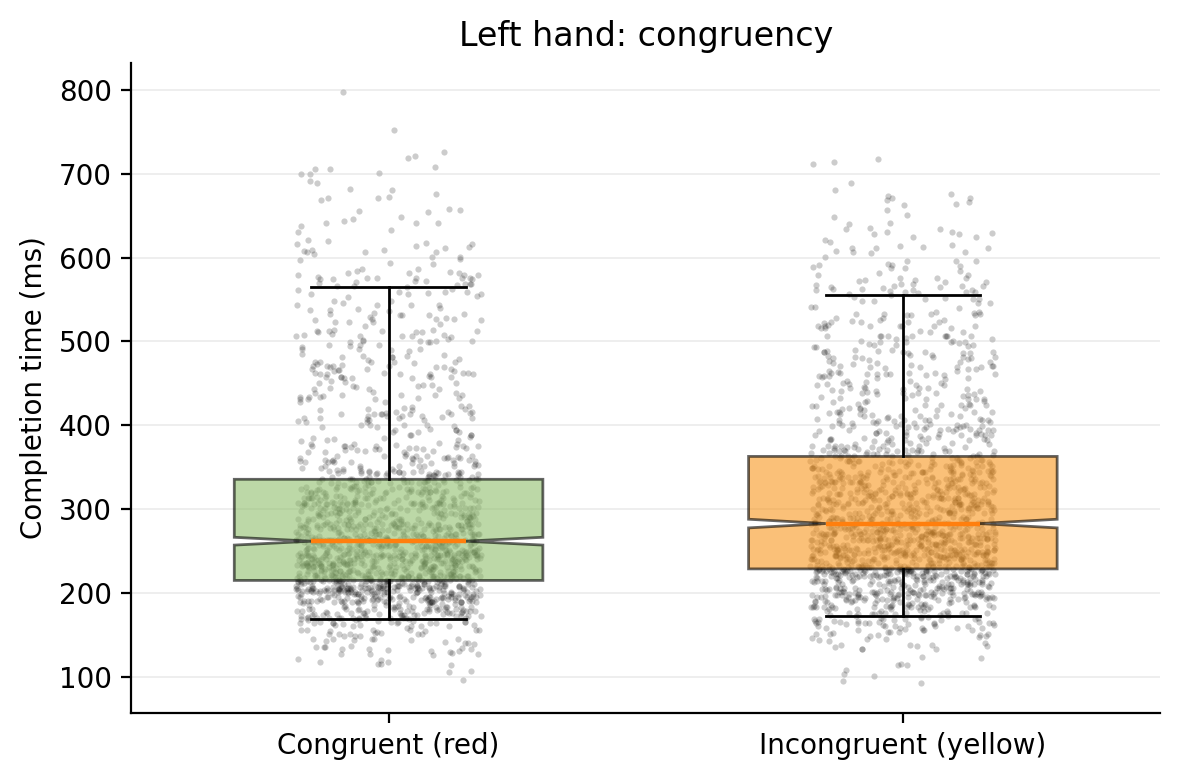

In [22]:
def overlay_jitter_scatter(ax, data_groups, x_positions, width=0.6, alpha=0.25, s=6):
    import numpy as np
    for x0, ys in zip(x_positions, data_groups):
        ys = np.asarray(ys, float)
        if ys.size == 0: 
            continue
        # slight jitter
        jitter = (np.random.rand(ys.size) - 0.5) * (width*0.6)
        ax.scatter(np.full_like(ys, x0, dtype=float) + jitter, ys, s=s, alpha=alpha, color='k', linewidths=0)

# Overlap scatter points on graph
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
bp = ax.boxplot(groups, labels=labels, notch=True, widths=0.6,
                showfliers=False, whis=(5,95),
                boxprops=dict(linewidth=1.0), medianprops=dict(linewidth=1.6),
                whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0),
                patch_artist=True)
for b,c in zip(bp['boxes'], colors):
    b.set_facecolor(c); b.set_alpha(0.6)

overlay_jitter_scatter(ax, groups, x_positions=[1,2], width=0.6, alpha=0.2, s=5)

ax.set_ylabel('Completion time (ms)')
ax.set_title('Left hand: congruency')
ax.grid(axis='y', alpha=0.25, linewidth=0.6)
plt.savefig('./complete_time_left.png', dpi=300)
plt.tight_layout(); plt.show()

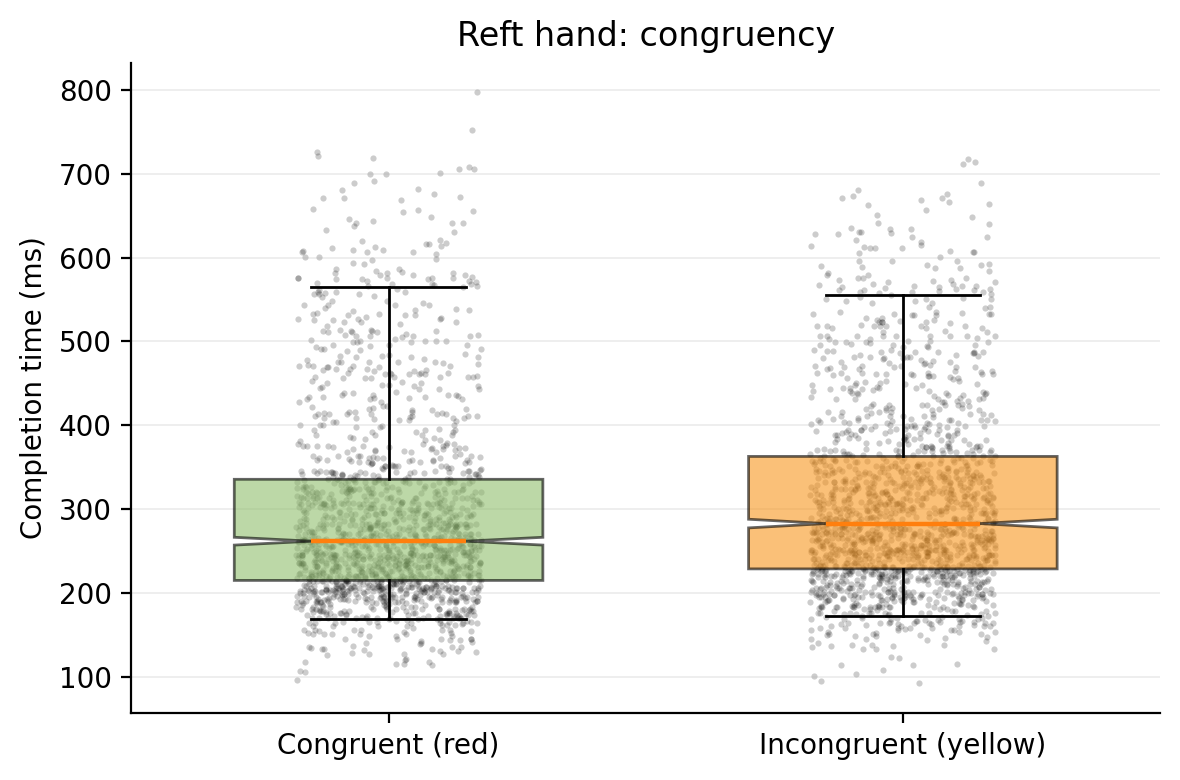

In [23]:
def overlay_jitter_scatter(ax, data_groups, x_positions, width=0.6, alpha=0.25, s=6):
    import numpy as np
    for x0, ys in zip(x_positions, data_groups):
        ys = np.asarray(ys, float)
        if ys.size == 0: 
            continue
        # slight jitter
        jitter = (np.random.rand(ys.size) - 0.5) * (width*0.6)
        ax.scatter(np.full_like(ys, x0, dtype=float) + jitter, ys, s=s, alpha=alpha, color='k', linewidths=0)

# Overlap scatter points on graph
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
bp = ax.boxplot(groups, labels=labels, notch=True, widths=0.6,
                showfliers=False, whis=(5,95),
                boxprops=dict(linewidth=1.0), medianprops=dict(linewidth=1.6),
                whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0),
                patch_artist=True)
for b,c in zip(bp['boxes'], colors):
    b.set_facecolor(c); b.set_alpha(0.6)

overlay_jitter_scatter(ax, groups, x_positions=[1,2], width=0.6, alpha=0.2, s=5)

ax.set_ylabel('Completion time (ms)')
ax.set_title('Reft hand: congruency')
ax.grid(axis='y', alpha=0.25, linewidth=0.6)
plt.savefig('./complete_time_right.png', dpi=300)
plt.tight_layout(); plt.show()


In [24]:
import numpy as np
import pandas as pd

dfc = df_clean.query("hand in ['L','R'] and congruency in ['congruent','incongruent']").copy()

# —— Each participant: average completion time of left/right hand (with n and sd) ——
per_subj_stats = (
    dfc.groupby(['subject','hand'])['duration_ms']
       .agg(mean='mean', sd=lambda x: np.std(x, ddof=1) if len(x)>1 else np.nan, n='count')
       .round(2)
       .unstack('hand')
)


cols = []
for side in ['L','R']:
    if (side in per_subj_stats.columns.levels[0]) or (side in per_subj_stats.columns):
        cols.extend([(side,'mean'), (side,'sd'), (side,'n')])
per_subj_stats = per_subj_stats.reindex(columns=cols)

print("—— Each participant: Completion time for left/right hand (mean ± sd, n)——")
display(per_subj_stats)

# —— Summary of all subjects: overall average completion time for left/right hands ——
overall_left_mean  = dfc.query("hand=='L'")['duration_ms'].mean()
overall_right_mean = dfc.query("hand=='R'")['duration_ms'].mean()
print(f"\nAll subjects, left hand, average completion time: {overall_left_mean:.2f} ms")
print(f"All subjects, right hand, average completion time: {overall_right_mean:.2f} ms")

# —— Consistency/inconsistency: The average completion time of all subjects combined ——
congruent_mean    = dfc.query("congruency=='congruent'")['duration_ms'].mean()
incongruent_mean  = dfc.query("congruency=='incongruent'")['duration_ms'].mean()
print(f"\n Consistency, average completion time: {congruent_mean:.2f} ms")
print(f"Incongruent, average completion time {incongruent_mean:.2f} ms")

—— Each participant: Completion time for left/right hand (mean ± sd, n)——


subject
s1
s10
s11
s12
s13
s14
s15
s2
s3
s4



All subjects, left hand, average completion time: 303.84 ms
All subjects, right hand, average completion time: 299.98 ms

 Consistency, average completion time: 294.53 ms
Incongruent, average completion time 309.23 ms


In [25]:
# List of completion times for all trials for each participant and each hand
for sid, subdf in dfc.groupby('subject'):
    print(f"\n=== {sid} ===")
    for hand in ['L','R']:
        arr = subdf.query("hand == @hand")['duration_ms'].to_numpy()
        if arr.size:
            print(f"{hand}: n={arr.size}, mean={arr.mean():.2f} ms -> {arr.tolist()[:20]}{' ...' if arr.size>20 else ''}")
        else:
            print(f"{hand}: No data")



=== s1 ===
L: n=157, mean=398.43 ms -> [282, 470, 336, 311, 326, 491, 349, 424, 361, 339, 436, 341, 266, 572, 352, 418, 348, 349, 386, 278] ...
R: n=154, mean=350.15 ms -> [377, 436, 319, 464, 454, 432, 408, 350, 300, 321, 363, 354, 357, 334, 323, 274, 356, 205, 280, 289] ...

=== s10 ===
L: n=238, mean=208.98 ms -> [133, 156, 198, 215, 227, 191, 234, 260, 243, 249, 281, 231, 234, 218, 225, 227, 214, 211, 161, 215] ...
R: n=237, mean=194.19 ms -> [206, 213, 195, 221, 215, 205, 206, 207, 183, 201, 214, 199, 201, 230, 214, 191, 249, 245, 233, 208] ...

=== s11 ===
L: n=240, mean=225.92 ms -> [344, 179, 488, 282, 288, 237, 337, 296, 356, 254, 369, 261, 325, 301, 304, 266, 326, 271, 258, 221] ...
R: n=240, mean=193.19 ms -> [226, 185, 291, 190, 181, 169, 196, 158, 209, 172, 196, 176, 267, 203, 236, 196, 216, 202, 196, 191] ...

=== s12 ===
L: n=157, mean=273.08 ms -> [163, 244, 271, 194, 263, 296, 238, 222, 226, 219, 229, 231, 201, 171, 246, 191, 228, 264, 253, 222] ...
R: n=227, mean=278

In [27]:
import os
import pandas as pd
import numpy as np

dfc = df_clean.query("hand in ['L','R'] and congruency in ['congruent','incongruent']").copy()

# 1. The average completion time for each participant's left/right hand (including n and sd)
per_subj = (
    dfc.groupby(['subject','hand'])['duration_ms']
       .agg(mean='mean', sd=lambda x: np.std(x, ddof=1) if len(x)>1 else np.nan, n='count')
       .reset_index()
)

# 2. Overall average of left and right hands
overall_L = dfc.query("hand=='L'")['duration_ms']
overall_R = dfc.query("hand=='R'")['duration_ms']
overall_rows = [
    {'subject': 'ALL', 'hand': 'L', 'mean': overall_L.mean(), 'sd': overall_L.std(ddof=1), 'n': len(overall_L)},
    {'subject': 'ALL', 'hand': 'R', 'mean': overall_R.mean(), 'sd': overall_R.std(ddof=1), 'n': len(overall_R)},
]
per_subj = pd.concat([per_subj, pd.DataFrame(overall_rows)], ignore_index=True)

# 3. Consistent/Inconsistent Overall Average
congruent = dfc.query("congruency=='congruent'")['duration_ms']
incongruent = dfc.query("congruency=='incongruent'")['duration_ms']
extra_rows = [
    {'subject': 'ALL', 'hand': 'ALL', 'mean': congruent.mean(), 'sd': congruent.std(ddof=1), 'n': len(congruent), 'note': 'congruent'},
    {'subject': 'ALL', 'hand': 'ALL', 'mean': incongruent.mean(), 'sd': incongruent.std(ddof=1), 'n': len(incongruent), 'note': 'incongruent'}
]
summary_df = pd.concat([per_subj, pd.DataFrame(extra_rows)], ignore_index=True)

# 4. Export CSV
out_csv = os.path.join("./completion_time_summary.csv")
summary_df.to_csv(out_csv, index=False)
print(f"[Export successful] {out_csv}")
display(summary_df.round(2))

[Export successful] ./completion_time_summary.csv


,subject,hand,mean,sd,n,note
0,s1,L,398.43,82.34,157,NaN
1,s1,R,350.15,70.10,154,NaN
2,s10,L,208.98,34.44,238,NaN
3,s10,R,194.19,31.52,237,NaN
4,s11,L,225.92,38.86,240,NaN
5,s11,R,193.19,30.33,240,NaN
6,s12,L,273.08,47.78,157,NaN
7,s12,R,278.77,45.78,227,NaN
8,s13,L,209.65,40.45,235,NaN
9,s13,R,210.96,42.58,232,NaN
